# DDPG Main

## Data Preprocessing

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data
#C:\Users\rohit\OneDrive\Documents\Asset-Pricing-with-Reinforcement-Learning\XOM_30_minute_6_month_data.csv
# df = pd.read_csv('XOM_30_minute_6_month_data.csv', parse_dates=['Date'])
from google.colab import drive
drive.mount('/content/drive')

OneDayFiveYears = '/content/drive/MyDrive/UniYear3/RL/XOM_1_day_5_years_price_data.csv'
ThirtyMinSixMonths = '/content/drive/MyDrive/UniYear3/RL/XOM_30_minute_6_month_data.csv'

# Load CSV data
df = pd.read_csv(ThirtyMinSixMonths)
df.sort_values('Date', inplace=True)

# Normalize
scaler = MinMaxScaler()
df[['Last Price', 'Volume', 'SMAVG (15)']] = scaler.fit_transform(df[['Last Price', 'Volume', 'SMAVG (15)']])

# Split into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

print(train_df[10:])

Mounted at /content/drive
                     Date  Last Price    Volume  SMAVG (15)
2345  2023-03-06 19:30:00    0.701005  0.088367         NaN
2344  2023-03-06 20:00:00    0.685666  0.067463         NaN
2343  2023-03-06 20:30:00    0.706041  0.203586         NaN
2342  2023-03-07 14:30:00    0.658422  0.154177         NaN
2341  2023-03-07 15:00:00    0.650180  0.116092    0.104411
...                   ...         ...       ...         ...
476   2023-09-29 19:00:00    0.853936  0.068144    0.135628
475   2023-09-29 19:30:00    0.876830  0.072069    0.134349
474   2023-09-29 20:00:00    0.874999  0.090113    0.137765
473   2023-09-29 20:30:00    0.881409  0.306496    0.180971
472   2023-10-02 14:30:00    0.794870  0.171930    0.194260

[1874 rows x 4 columns]


In [4]:
%pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.0 MB/s eta 0:00:00


## Environment

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium
from gymnasium import spaces
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


class DDPGTradingEnv(gymnasium.Env):

  def __init__(self, df):
    super().__init__()

    self.df = df
    self.current_step = 0
    self.total_steps = len(df) - 1

    # Negatives mean quantity to sell, 0 is hold, positives mean buy
    self.action_space = spaces.Box(low=-1, high=1, shape=(1, ), dtype=np.float32)
    # Observation space: normalized last price, normalized shares held, normalized cash balance
    self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)

    self.reset()

  def reset(self):
    self.current_step = 0
    self.total_profit = 0
    self.initial_balance = 10000
    self.cash_balance = self.initial_balance
    self.shares_held = 0
    self.portfolio_value = self.cash_balance

    self.previous_portfolio_value = self.portfolio_value
    # For plotting
    self.portfolio_history = [self.portfolio_value]

    return self.get_observation()

  def get_observation(self):
    current_price = self.df.loc[self.current_step, 'Last Price']
    return np.array([current_price, self.shares_held, self.cash_balance])

  # Action space is one number between -1 and 1.
  def take_action(self, action_value):
    current_price = self.df.loc[self.current_step, 'Last Price']
    if action_value > 0:
      self.buy_stock(action_value, current_price)
    elif action_value < 0:
      self.sell_stock(action_value, current_price)
    # Update the portfolio value
    self.previous_portfolio_value = self.portfolio_value
    self.portfolio_value = self.cash_balance + (self.shares_held * current_price)

  def buy_stock(self, num_stocks, current_price):
    self.cash_balance -= (num_stocks * current_price)
    self.shares_held += num_stocks

  def sell_stock(self, num_stocks, current_price):
    self.cash_balance += (num_stocks * current_price)
    self.shares_held -= num_stocks

  def step(self, action):
    self.current_step += 1
    self.take_action(action)
    reward = self.calculate_reward()
    terminated = (self.current_step >= len(self.df) - 1)
    observation = self.get_observation()
    info = {'current_step': self.current_step, 'portfolio_value': self.portfolio_value}
    self.portfolio_history.append(self.portfolio_value)
    return observation, reward, terminated, info

  def render(self, mode='human'):
    if mode == 'human':
      print(f"Step: {self.current_step}, Portfolio Value: {self.portfolio_value}")

  # The reward is the change in portfolio value the next time_step
  def calculate_reward(self):
    reward = self.portfolio_value - self.previous_portfolio_value
    return reward

## DDPG Classes

In [6]:
# Because DDPG is an off-policy actor-critic policy-gradient algorithm, this means that the critic
# evaluates the actor, but because they are off-policy, the agents act according to their own
# policy but learn according to the target policy.

import random
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Initialise environment:
env = DDPGTradingEnv(df)

# # Pseudocode line 1:
# # Initialize replay memory 𝐷 to capacity 𝑁
# N = 1000
# replay_memory = []
# # replay_memory = deque(maxlen=N)
# # Initialise minibatch size
# minibatch_size = 50

# # Input: Current state
# # Output: Action to be taken
# # class Actor(nn.Module):
# #     def __init__(self, input_dim, output_dim, hidden_size=128):
# #         super(Actor, self).__init__()

# #     def forward(self, state):
# #         return 0.5

# # # Input: Current State & Actor's action
# # # Output: Expected value of state-action pair
# # class Critic(nn.Module):
# #     def __init__(self, input_dim, output_dim, hidden_size=128):
# #         super(Critic, self).__init__()

# #     def forward(self, state, action):
# #         return 0.5

# # Pseudocode line 2 & 3:
# # Initialize actor network 𝜋̂ 1 with parameters 𝒘1 arbitrarily
# # Initialize target actor network 𝜋̂ 2 with parameters 𝒘2=𝒘1
# state_dim = 3
# action_dim = 1
# actor_model = Actor(state_dim, action_dim)
# target_actor_model = Actor(state_dim, action_dim)

# # Pseudocode line 4 & 5:
# # Initialize critic network 𝑞̂ 1 with parameters 𝜽1 arbitrarily
# # Initialize target critic network 𝑞̂ 2 with parameters 𝜽2=𝜽1
# critic_model = Critic(state_dim + action_dim, 1)
# target_critic_model = Critic(state_dim + action_dim, 1)

# # Pseudocode line 6: Algorithm parameters: target network learning rate 𝛽>0
# beta = 0.005
# # Gamma is the discount factor (importance of future rewards)
# gamma = 0.9

# # This is for the gradient descent, we will probably put this in a learn method in the DDPG class
# lr = 0.005
# optimizer_critic = optim.Adam(critic_model.parameters(), lr=lr)
# optimizer_actor = optim.Adam(actor_model.parameters(), lr=lr)

# # Loop for each episode:
# num_episodes = 100
# for i in range(num_episodes):
#     # Initialise random process ϵ for action exploration
#     epsilon = 0.1
#     # Initialise S
#     state = env.reset()

#     # Loop for each step of episode (each time step in df)
#     terminated = False
#     while not terminated:
#         # Select action 𝐴←𝜋̂ 1(𝑆,𝒘1)+
#         action = actor_model.forward(state)
#         # Execute action 𝐴, observe reward 𝑅 and next-state 𝑆′
#         new_state, reward, terminated, info = env.step(action)
#         # Store transition (𝑆,𝐴,𝑅,𝑆′) in 𝐷
#         transition = (state, action, reward, new_state)
#         replay_memory.append(transition)
#         # For each transition (𝑆𝑗,𝐴𝑗,𝑅𝑗,𝑆′𝑗) in minibatch sampled from 𝐷:
#         minibatch_sampled_from_D = random.sample(replay_memory, minibatch_size)
#         for transition in minibatch_sampled_from_D:
#             # 𝑦←𝑅𝑗+𝛾𝑞̂ 2(𝑆′𝑗,𝜋̂ 2(𝑆′𝑗,𝒘2),𝜽2)
#             state, action, reward, new_state = transition
#             # 𝜋̂ 2(𝑆′𝑗,𝒘2)
#             target_actor_model_output = target_actor_model.forward(new_state)
#             y = reward + gamma * target_critic_model.forward(new_state, target_actor_model_output)
#             # Perform gradient descent step ∇𝜽1(𝑦−𝑞̂ 1(𝑆𝑗,𝐴𝑗,𝜽1))2 for critic (critic learning from target critic)
#             critic_output = critic_model.forward(state, action)
#             critic_loss = F.mse_loss(critic_output, y)
#             optimizer_critic.zero_grad()
#             critic_loss.backward()
#             optimizer_critic.step()
#             # Perform gradient ascent step ∇𝑤1𝐸[𝑞̂ 1(𝑆𝑗,𝜋̂ 1(𝑆𝑗,𝒘1),𝜽1)] for actor (actor learning from critic)
#             actor_output = actor_model.forward(state)
#             actor_loss = -torch.mean(critic_model(state, actor_output))
#             optimizer_actor.zero_grad()
#             actor_loss.backward()
#             optimizer_actor.step()
#         # Update target actor network parameters 𝒘2←𝛽𝒘1+(1−𝛽)𝒘2

#         # Update target critic network parameters 𝜽2←𝛽𝜽1+(1−𝛽)𝜽2





### Actor Class TEST

In [7]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden1_units, hidden2_units):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden1_units)
        self.fc2 = nn.Linear(hidden1_units, hidden2_units)
        self.fc3 = nn.Linear(hidden2_units, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))  # Output with tanh activation for bounded actions
        return x

### Critic Class TEST

In [10]:
# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden1_units, hidden2_units):
        super(Critic, self).__init__()
        self.fc1_state = nn.Linear(state_dim, hidden1_units)
        self.fc2_state = nn.Linear(hidden1_units, hidden2_units)

        self.fc2_action = nn.Linear(action_dim, hidden2_units)

        self.fc3 = nn.Linear(hidden2_units * 2, 1)  # Combined layer

    def forward(self, state, action):
        x_state = F.relu(self.fc1_state(state))
        x_state = F.relu(self.fc2_state(x_state))

        x_action = F.relu(self.fc2_action(action))

        x = torch.cat((x_state, x_action), dim=1)
        x = F.relu(x)
        x = self.fc3(x)  # Q-value output
        return x

## Training TEST

In [26]:
# Initialize networks
state_dim = 3
action_dim = 1
hidden1_units = 64  # Number of units in the first hidden layer
hidden2_units = 64  # Number of units in the second hidden layer
actor_model = Actor(state_dim, action_dim, hidden1_units, hidden2_units)
critic_model = Critic(state_dim, action_dim, hidden1_units, hidden2_units)

target_actor_model = Actor(state_dim, action_dim, hidden1_units, hidden2_units)
target_critic_model = Critic(state_dim, action_dim, hidden1_units, hidden2_units)

# Set target networks' parameters equal to the main networks' parameters
target_actor_model.load_state_dict(actor_model.state_dict())
target_critic_model.load_state_dict(critic_model.state_dict())

# Define algorithm parameters
beta = 0.005
gamma = 0.9
lr = 0.005
optimizer_critic = optim.Adam(critic_model.parameters(), lr=lr)
optimizer_actor = optim.Adam(actor_model.parameters(), lr=lr)

# Initialize environment and replay memory
# env = ...  # Initialize your environment
replay_memory = []  # Initialize your replay memory

num_episodes = 50
minibatch_size = 64

# for i in range(num_episodes):
#     epsilon = 0.1
#     state = env.reset()
#     terminated = False

#     while not terminated:
#         action = actor_model(torch.FloatTensor(state))
#         action = action.detach().numpy()
#         # Add exploration noise (optional)
#         action += epsilon * np.random.randn(action_dim)

#         new_state, reward, terminated, info = env.step(action)
#         # print(new_state)
#         new_state = [new_state[0],new_state[1],new_state[2]] # because new_state is originally an numpy array object and torch couldn't change that to tensor
#         # print(type(new_state),type(reward),type(terminated),type(info))

#         transition = (torch.FloatTensor(state), torch.FloatTensor(action), reward, torch.FloatTensor(new_state))
#         replay_memory.append(transition)

#         # Sample a minibatch from the replay memory
#         if len(replay_memory) <= minibatch_size:
#             minibatch_sampled_from_D = replay_memory
#         else:
#             minibatch_sampled_from_D = random.sample(replay_memory, minibatch_size)

#         for transition in minibatch_sampled_from_D:
#                 state, action, reward, new_state = transition

#                 new_state_tensor = torch.FloatTensor(new_state)

#                 target_actor_output = target_actor_model(new_state_tensor)

#                 reward_tensor = torch.FloatTensor(reward)
#                 y = reward_tensor + gamma * target_critic_model(new_state_tensor, target_actor_output)

#                 critic_output = critic_model(state, action)
#                 critic_loss = nn.MSELoss()(critic_output, y.detach())

#                 optimizer_critic.zero_grad()
#                 critic_loss.backward()
#                 optimizer_critic.step()

#                 # Update actor
#                 actor_output = actor_model(state)
#                 actor_loss = -torch.mean(critic_model(state, actor_output))

#                 optimizer_actor.zero_grad()
#                 actor_loss.backward()
#                 optimizer_actor.step()

#                 # Soft update of target networks
#                 for target_param, param in zip(target_actor_model.parameters(), actor_model.parameters()):
#                     target_param.data.copy_(beta * param.data + (1 - beta) * target_param.data)

#                 for target_param, param in zip(target_critic_model.parameters(), critic_model.parameters()):
#                     target_param.data.copy_(beta * param.data + (1 - beta) * target_param.data)

#                 state = new_state  # Update the current state
total_loss = []
for i in range(num_episodes):
    epsilon = 0.1
    state = env.reset()
    terminated = False
    loss = []
    while not terminated:
        action = actor_model(torch.FloatTensor(state)).detach().numpy()
        action += epsilon * np.random.randn(action_dim)

        new_state, reward, terminated, info = env.step(action)
        new_state = torch.FloatTensor([new_state[0], new_state[1], new_state[2]])

        transition = (torch.FloatTensor(state), torch.FloatTensor(action), torch.FloatTensor([reward]), new_state)
        replay_memory.append(transition)

        state = new_state  # Update the current state

    if len(replay_memory) > minibatch_size:
        minibatch = random.sample(replay_memory, minibatch_size)
        batch = list(zip(*minibatch))

        states_batch = torch.stack(batch[0])
        actions_batch = torch.stack(batch[1])
        rewards_batch = torch.stack(batch[2])
        next_states_batch = torch.stack(batch[3])

        target_actor_outputs = target_actor_model(next_states_batch)
        target_critic_values = target_critic_model(next_states_batch, target_actor_outputs).detach()

        y = rewards_batch + gamma * target_critic_values

        # Update critic
        critic_outputs = critic_model(states_batch, actions_batch)
        critic_loss = F.mse_loss(critic_outputs, y)
        optimizer_critic.zero_grad()
        critic_loss.backward()
        optimizer_critic.step()

        # Update actor
        actor_outputs = actor_model(states_batch)
        actor_loss = -torch.mean(critic_model(states_batch, actor_outputs))

        loss.append(-1 * actor_loss.detach().numpy())

        optimizer_actor.zero_grad()
        actor_loss.backward()
        optimizer_actor.step()

        # Soft update of target networks
        for target_param, param in zip(target_actor_model.parameters(), actor_model.parameters()):
            target_param.data.copy_(beta * param.data + (1 - beta) * target_param.data)

        for target_param, param in zip(target_critic_model.parameters(), critic_model.parameters()):
            target_param.data.copy_(beta * param.data + (1 - beta) * target_param.data)

    x = np.mean(loss)
    total_loss.append(x)

<ipython-input-5-488850091d8d>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([current_price, self.shares_held, self.cash_balance])
<ipython-input-26-eb77438ffd80>:122: UserWarning: Using a target size (torch.Size([64, 64, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(critic_outputs, y)


In [16]:
# Set the actor model to evaluation mode
actor_model.eval()

# Number of episodes for testing
num_test_episodes = 10

for episode in range(num_test_episodes):
    state = env.reset()
    terminated = False
    total_reward = 0

    while not terminated:
        # Use the trained actor to select actions (no exploration noise during testing)
        with torch.no_grad():
            action = actor_model(torch.FloatTensor(state)).detach().numpy()

        # Take the action in the environment
        new_state, reward, terminated, _ = env.step(action)
        total_reward += reward
        state = torch.FloatTensor([new_state[0], new_state[1], new_state[2]])

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

<ipython-input-5-488850091d8d>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([current_price, self.shares_held, self.cash_balance])


Episode 1, Total Reward: [379.82422]
Episode 2, Total Reward: [379.82422]
Episode 3, Total Reward: [379.82422]
Episode 4, Total Reward: [379.82422]
Episode 5, Total Reward: [379.82422]
Episode 6, Total Reward: [379.82422]
Episode 7, Total Reward: [379.82422]
Episode 8, Total Reward: [379.82422]
Episode 9, Total Reward: [379.82422]
Episode 10, Total Reward: [379.82422]


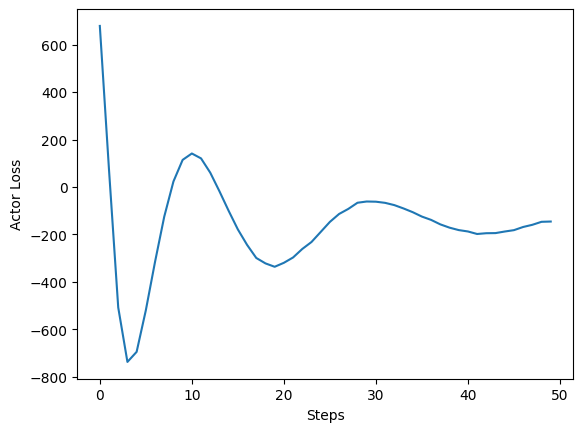

In [27]:
import matplotlib.pyplot as plt

# Plotting the profit change
#plt.plot(env.portfolio_history)
plt.plot(total_loss)
#plt.title("Profit Change Over Time")
plt.xlabel("Steps")
plt.ylabel("Actor Loss")
plt.show()